## Praca domowa 2 - Jan Król

### Wstęp

Tematem mojej pracy domowej jest analiza cen wynajmu mieszkań w Nowym Jorku oraz innych własności. Na ich podstawie klasyfikatory przypisują nieruchomości przedział cenowy. Korzystam z bazy danych numeryczno-kategorycznej New York Realstate Pricing. Używane algorytmy to: drzewo decyzyjne, k najbliższych sąsiadów, naiwny Bayes oraz sieć neuronowa. W celu lepszej analizy danych podjąłem decyzję o zastąpieniu wszystkich wartości tekstowych na liczbowe. Dotyczy to kolumn: "neighbourhood" i "room type". Odpowiadające im oryginalne wartości umieściłem w pliku dict.py.

### Importowanie zależności

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.tree as tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

### Preprocessing

Każdy klasyfikator bada dwie wersje mojej bazy danych. Zostaje ona poddana wstępnemu przetworzeniu i dopiero później zostaje mu przekazana do treningu. Pierwszą wersją jest baza danych po normalizacji z-score. Każda wartość w kolumach staje się różnicą niej samej ze średnią podzieloną przez ochylenie standardowe. Drugią wersją jest baza danych zoptymalizowana algorytmem PCA, który redukuje liczbę kolumn.  

In [2]:
def prepare_pca(df, n_components=4):
	pca = PCA(n_components)
	pca.fit(df)
	def transform_pca(data):
		return pca.transform(data)
	return transform_pca

### Wstępne przygotowanie danych

Poniższy kod odpowiada za pobieranie danych z pliku .csv. i utworzenie przedziałów cenowych, które będą przypisywanymi klasami.

In [4]:
df = pd.read_csv("NY_Realstate_Pricing.csv")
df = df[df["price"] < 1200]
feature_names = ["neighbourhood", "latitude","longitude","room_type","days_occupied_in_2019","minimum_nights","number_of_reviews","reviews_per_month","availability_2020"]
all_inputs = df[feature_names].values
all_classes = df["price"].values
categories_count = 10
min_price = all_classes.min()
max_price = all_classes.max()
category_size = (max_price - min_price) / categories_count
categires_as_int = [math.floor((n - min_price) / category_size) for n in all_classes]
categories_as_str = [str(min_price + category_size * i) + "-" + str(min_price + category_size * (i+1)) for i in categires_as_int]
X = df[feature_names]
y = df["price"]
print(categories_as_str)

['117.7-235.4', '0.0-117.7', '117.7-235.4', '0.0-117.7', '0.0-117.7', '117.7-235.4', '0.0-117.7', '0.0-117.7', '117.7-235.4', '117.7-235.4', '117.7-235.4', '0.0-117.7', '235.4-353.1', '0.0-117.7', '0.0-117.7', '0.0-117.7', '117.7-235.4', '0.0-117.7', '0.0-117.7', '117.7-235.4', '0.0-117.7', '0.0-117.7', '0.0-117.7', '0.0-117.7', '0.0-117.7', '0.0-117.7', '0.0-117.7', '0.0-117.7', '117.7-235.4', '117.7-235.4', '117.7-235.4', '117.7-235.4', '0.0-117.7', '117.7-235.4', '0.0-117.7', '0.0-117.7', '117.7-235.4', '117.7-235.4', '117.7-235.4', '117.7-235.4', '117.7-235.4', '0.0-117.7', '0.0-117.7', '0.0-117.7', '0.0-117.7', '117.7-235.4', '0.0-117.7', '0.0-117.7', '117.7-235.4', '0.0-117.7', '0.0-117.7', '0.0-117.7', '235.4-353.1', '0.0-117.7', '117.7-235.4', '0.0-117.7', '0.0-117.7', '0.0-117.7', '117.7-235.4', '0.0-117.7', '0.0-117.7', '117.7-235.4', '117.7-235.4', '0.0-117.7', '235.4-353.1', '117.7-235.4', '0.0-117.7', '0.0-117.7', '0.0-117.7', '0.0-117.7', '0.0-117.7', '117.7-235.4', '0.0-

### Drzewo decyzyjne

In [5]:
pca_transform = prepare_pca(all_inputs,7)
all_inputs = pca_transform(all_inputs)
dtc = DecisionTreeClassifier()
(train_inputs, test_inputs, train_classes, test_classes) = train_test_split(all_inputs, categories_as_str, train_size=0.7, random_state=1)
dtc.fit(train_inputs, train_classes)
predicted_classes = dtc.predict(test_inputs)
accuracy = accuracy_score(test_classes, predicted_classes)
cm = confusion_matrix(test_classes, predicted_classes)
print(accuracy)
print(cm)

0.5785578747628084
[[2063    0  616    0  101   17   17    4    4    0    4]
 [   1    0    1    0    0    1    0    0    0    0    0]
 [ 605    2  902    0  189   58   44   13    6    2    8]
 [   0    0    1    0    0    0    0    0    0    0    0]
 [  95    0  214    0   71    7   13    5    1    0    3]
 [  26    0   39    0   13    7    4    1    0    0    1]
 [   9    0   16    0    7    2    1    0    1    1    0]
 [   6    0   16    0    5    1    3    2    2    0    0]
 [   5    0    8    0    3    0    1    0    2    0    0]
 [   1    0    4    0    1    0    0    0    1    0    0]
 [   3    0    3    0    5    1    0    0    0    0    1]]


In [6]:
scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
test_inputs = scaler.transform(test_inputs)
dtc = DecisionTreeClassifier()
dtc.fit(train_inputs, train_classes)
predicted_classes = dtc.predict(test_inputs)
accuracy = accuracy_score(test_classes, predicted_classes)
cm = confusion_matrix(test_classes, predicted_classes)
print(accuracy)
print(cm)

0.581404174573055
[[2067    0  609    0  105   19   13    4    4    1    4]
 [   1    0    1    0    0    1    0    0    0    0    0]
 [ 602    1  912    0  203   51   31   14    8    1    6]
 [   0    0    1    0    0    0    0    0    0    0    0]
 [  95    0  214    0   70   10   13    3    0    0    4]
 [  20    0   38    0   18    8    4    1    1    0    1]
 [  11    0   14    0    6    2    2    0    1    1    0]
 [   7    0   14    0    8    0    3    2    1    0    0]
 [   5    0    9    0    1    0    0    0    3    0    1]
 [   0    0    4    0    2    0    0    0    1    0    0]
 [   3    0    4    0    5    0    0    0    1    0    0]]


### k najbliższych sąsiadów

In [7]:
pca_transform = prepare_pca(X, 7)
X = pca_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, categories_as_str, test_size=0.3)
k = 21
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
cm = confusion_matrix(y_test, y_pred)
print(cm)

0.5476280834914611
[[2356    0  475    3    0    0    0    0    0    0]
 [   2    0    0    0    0    0    0    0    0    0]
 [1288    0  529    1    0    0    0    0    0    0]
 [ 269    0  144    1    0    0    0    0    0    0]
 [  69    0   26    0    0    0    0    0    0    0]
 [  31    0   11    0    0    0    0    0    0    0]
 [  19    0    6    0    0    0    0    0    0    0]
 [  15    0    5    0    0    0    0    0    0    0]
 [   5    0    1    0    0    0    0    0    0    0]
 [  11    0    3    0    0    0    0    0    0    0]]


In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
k = 21
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
cm = confusion_matrix(y_test, y_pred)
print(cm)

0.6916508538899431
[[2256    0  574    4    0    0    0    0    0    0]
 [   1    0    1    0    0    0    0    0    0    0]
 [ 420    0 1381   17    0    0    0    0    0    0]
 [  49    0  357    8    0    0    0    0    0    0]
 [   7    0   84    4    0    0    0    0    0    0]
 [   6    0   36    0    0    0    0    0    0    0]
 [   6    0   18    1    0    0    0    0    0    0]
 [   4    0   15    1    0    0    0    0    0    0]
 [   0    0    6    0    0    0    0    0    0    0]
 [   2    0   11    1    0    0    0    0    0    0]]


### Naiwny Bayes

In [9]:
pca_transform = prepare_pca(X, 7)
X = pca_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, categories_as_str, test_size=0.3)
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(accuracy)
print(cm)

0.6703984819734345
[[2183   13  600    0    3    0    0    0    0    0]
 [   0    0    2    0    0    0    0    0    0    0]
 [ 501    3 1350    0    7    0    0    0    0    0]
 [  67    2  342    0    1    0    0    0    0    0]
 [  16    1   80    0    0    0    0    0    0    0]
 [   6    0   31    0    0    0    0    0    0    0]
 [   5    3   20    0    0    0    0    0    0    0]
 [   1    1   14    0    0    0    0    0    0    0]
 [   1    0    5    0    0    0    0    0    0    0]
 [   3    0    9    0    0    0    0    0    0    0]]


In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(accuracy)
print(cm)

0.6705882352941176
[[2184   13  599    0    3    0    0    0    0    0]
 [   0    0    2    0    0    0    0    0    0    0]
 [ 501    3 1350    0    7    0    0    0    0    0]
 [  67    2  342    0    1    0    0    0    0    0]
 [  16    1   80    0    0    0    0    0    0    0]
 [   6    0   31    0    0    0    0    0    0    0]
 [   5    3   20    0    0    0    0    0    0    0]
 [   1    1   14    0    0    0    0    0    0    0]
 [   1    0    5    0    0    0    0    0    0    0]
 [   3    0    9    0    0    0    0    0    0    0]]


### Sieć neuronowa

Poniższa sieć neuronowa zawiera warstwę ukrytą z sześcioma neuronami oraz wyjściową z trzema. Jej konfiguracja obejmuje także maksymalną liczbę iteracji na 500 oraz funkcję aktywacji ReLU.

0.5442125237191651
[[2849    2 1786    0  375   88   46   31   19    6   13]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  25    0   19    0    5    3    2    0    0    0    0]
 [   0    0    1    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]]


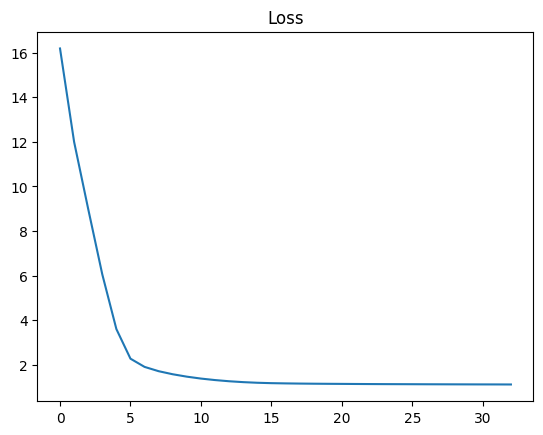

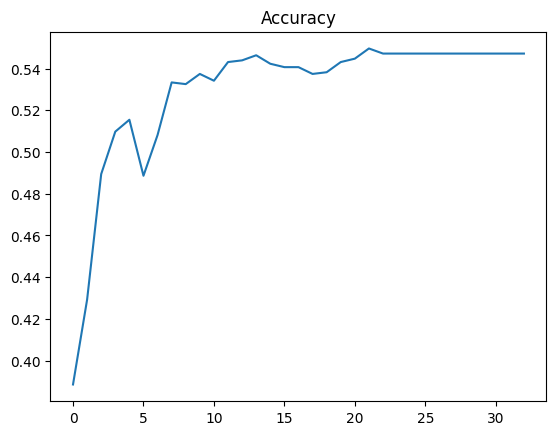

In [11]:
pca_transform = prepare_pca(X, 7)
X = pca_transform(X)
train_data, test_data, train_labels, test_labels = train_test_split(X, categories_as_str, test_size=0.3)
mlp = MLPClassifier(hidden_layer_sizes=(6, 3), activation='relu', max_iter=500, early_stopping=True)
mlp.fit(train_data, train_labels)
predictions = mlp.predict(test_data)
accuracy = accuracy_score(predictions, test_labels)
cm = confusion_matrix(predictions, test_labels)
print(accuracy)
print(cm)
plt.plot(mlp.loss_curve_)
plt.title("Loss")
plt.show()
plt.plot(mlp.validation_scores_)
plt.title("Accuracy")
plt.show()

0.6874762808349146
[[2095    1  278   23    8    2    3    2    1    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [ 779    1 1528  357   83   46   28   17    5   13]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


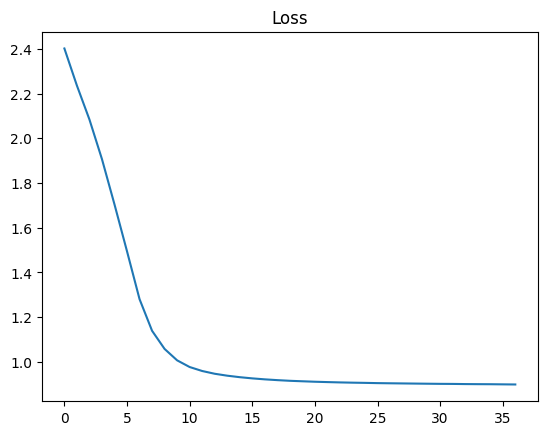

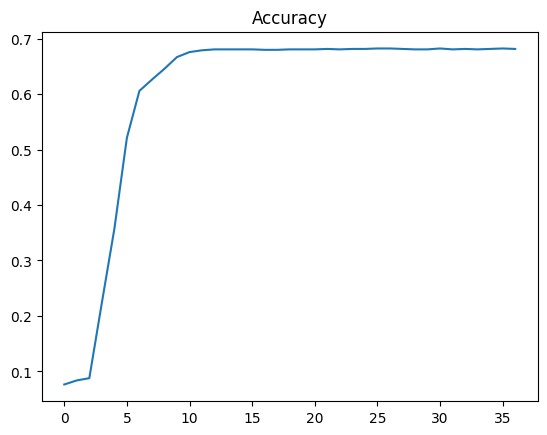

In [12]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
mlp = MLPClassifier(hidden_layer_sizes=(6, 3), activation='relu', max_iter=500, early_stopping=True)
mlp.fit(train_data, train_labels)
predictions = mlp.predict(test_data)
accuracy = accuracy_score(predictions, test_labels)
cm = confusion_matrix(predictions, test_labels)
print(accuracy)
print(cm)
plt.plot(mlp.loss_curve_)
plt.title("Loss")
plt.show()
plt.plot(mlp.validation_scores_)
plt.title("Accuracy")
plt.show()


### Podsumowanie

| Klasyfikator | PCA | Normalizacja z-score|
|:------------:|:---:|:--------------------|
|**drzewo decyzyjne**|58%|58%|
|**k najbliższych sąsiadów**|53%|69%|
|**naiwny Bayes**|66%|66%|
|**sieć neuronowa**|66%|69%|

Z powyższego zestawienia wynika, że największą dokładność osiągają algorytmy: k najbliższych sąsiadów i sieć neuronowa, które pracują na bazie danych poddanej normalizacji z-score. Należy dodać, że oba te algorytmy mają tak dobrane parametry, aby zwracały jak najlepszy wynik. W tym przypadku mówimy o 21 najbliższych sąsiadach oraz sieci neuronowej z dwiema warstwami zawierającymi odpowiednio 6 i 3 neurony.

### Bibliografia

Scikit-learn docs: https://scikit-learn.org/stable/
